In [80]:
import os
import sys

import numpy as np
from pandas.io.json import read_json
from sklearn.utils import shuffle
import lasagne
from lasagne import layers
from lasagne.updates import nesterov_momentum
from nolearn.lasagne import NeuralNet, TrainSplit
import theano
import cPickle as pickle

from datetime import datetime
import re

In [6]:
FTRAIN = '../data/train.json'
FTEST = '../data/test.json'

In [7]:
df = read_json(FTRAIN)

In [8]:
df.columns

Index([u'bathrooms', u'bedrooms', u'building_id', u'created', u'description',
       u'display_address', u'features', u'interest_level', u'latitude',
       u'listing_id', u'longitude', u'manager_id', u'photos', u'price',
       u'street_address'],
      dtype='object')

In [9]:
df = df[[u'bathrooms', u'bedrooms', u'created', u'description', u'features', u'interest_level', u'latitude',
         u'longitude', u'photos', u'price']]

In [10]:
df['price_per_bathroom'] = df['price']/(df['bathrooms']+1)
df['price_per_bedroom'] = df['price']/(df['bedrooms']+1)

In [12]:
df.head()['created']

10        2016-06-24 07:54:24
10000     2016-06-12 12:19:27
100004    2016-04-17 03:26:41
100007    2016-04-18 02:22:02
100013    2016-04-28 01:32:41
Name: created, dtype: object

In [14]:
df['created'] = df['created'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))

In [15]:
df.head()['created']

10       2016-06-24 07:54:24
10000    2016-06-12 12:19:27
100004   2016-04-17 03:26:41
100007   2016-04-18 02:22:02
100013   2016-04-28 01:32:41
Name: created, dtype: datetime64[ns]

In [18]:
testcreated = df.iloc[0]['created']
testcreated

Timestamp('2016-06-24 07:54:24')

In [33]:
testcreated.weekday()

4

In [22]:
df['day_of_month'] = df['created'].apply(lambda x: x.day)

In [28]:
df['hour'] = df['created'].apply(lambda x: x.hour + (x.minute + x.second / 60.0) / 60.0)

In [34]:
df['day_of_week'] = df['created'].apply(lambda x: x.weekday())

In [35]:
del df['created']

In [36]:
df.columns

Index([         u'bathrooms',           u'bedrooms',        u'description',
                 u'features',     u'interest_level',           u'latitude',
                u'longitude',             u'photos',              u'price',
       u'price_per_bathroom',  u'price_per_bedroom',       u'day_of_month',
                     u'hour',        u'day_of_week'],
      dtype='object')

In [41]:
len([x for x in re.split(r'\W+', 'come live here! At 25 Broadway.') if len(x) > 0])

6

In [42]:
re.split(r'\W+', 'come live here! At 25 Broadway.')

['come', 'live', 'here', 'At', '25', 'Broadway', '']

In [43]:
df['desc_len'] = df['description'].apply(lambda desc: len([x for x in re.split(r'\W+', desc) if len(x) > 0]))

In [44]:
df['num_features'] = df['features'].apply(len)

In [45]:
df['features_len'] = df['features'].apply(lambda feats: sum([len([x for x in re.split(r'\W+', feat) if len(x) > 0]) for feat in feats]))

In [46]:
del df['features']

In [49]:
df.columns

Index([         u'bathrooms',           u'bedrooms',     u'interest_level',
                 u'latitude',          u'longitude',             u'photos',
                    u'price', u'price_per_bathroom',  u'price_per_bedroom',
             u'day_of_month',               u'hour',        u'day_of_week',
                 u'desc_len',       u'num_features',       u'features_len'],
      dtype='object')

In [48]:
del df['description']

In [51]:
df['num_photos'] = df['photos'].apply(len)

In [52]:
del df['photos']

In [53]:
df.columns

Index([         u'bathrooms',           u'bedrooms',     u'interest_level',
                 u'latitude',          u'longitude',              u'price',
       u'price_per_bathroom',  u'price_per_bedroom',       u'day_of_month',
                     u'hour',        u'day_of_week',           u'desc_len',
             u'num_features',       u'features_len',         u'num_photos'],
      dtype='object')

In [54]:
X = np.array(df[[col for col in df.columns if col != 'interest_level']], dtype = np.float)

In [55]:
X.shape

(49352, 14)

In [56]:
X_max = X.max(axis = 0)

In [57]:
X_max

array([  1.00000000e+01,   8.00000000e+00,   4.48835000e+01,
         0.00000000e+00,   4.49000000e+06,   2.24500000e+06,
         1.49666667e+06,   3.10000000e+01,   2.39977778e+01,
         6.00000000e+00,   6.94000000e+02,   3.90000000e+01,
         1.30000000e+02,   6.80000000e+01])

In [58]:
X_min = X.min(axis = 0)
X_min

array([  0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
        -1.18271000e+02,   4.30000000e+01,   2.15000000e+01,
         4.30000000e+01,   1.00000000e+00,   2.83333333e-02,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00])

In [59]:
X = (X - X_min) / (X_max - X_min)

In [60]:
X.max(axis = 0)

array([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.])

In [61]:
X.min(axis = 0)

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])

In [66]:
y_dummies = pd.get_dummies(df['interest_level'])
y = y_dummies.as_matrix()

In [64]:
y.shape

(49352, 3)

In [65]:
y

array([[0, 0, 1],
       [0, 1, 0],
       [1, 0, 0],
       ..., 
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0]], dtype=uint8)

In [67]:
y_dummies.head()

,high,low,medium
10,0,0,1
10000,0,1,0
100004,1,0,0
100007,0,1,0
100013,0,1,0


In [69]:
subset = np.random.choice(X.shape[0], 1000, replace = False)
X_sub = X[subset]
y_sub = y[subset]

In [71]:
X_sub.shape

(1000, 14)

In [74]:
def float32(k):
    return np.cast['float32'](k)

In [77]:
y = y.astype(np.float32)

In [102]:
net = NeuralNet(
    layers = [
        ('input', layers.InputLayer),
        ('hidden1', layers.DenseLayer),
        ('hidden2', layers.DenseLayer),
        ('output', layers.DenseLayer)],
    input_shape=(None, 14),
    hidden1_num_units = 1000,
    hidden2_num_units = 1000,
    output_num_units = 3, output_nonlinearity = lasagne.nonlinearities.softmax,
    update=nesterov_momentum,
    update_learning_rate=theano.shared(float32(0.1)),
    update_momentum=theano.shared(float32(0.9)),
    max_epochs = 1000,
    verbose = 1,
    regression = True,
    objective_loss_function = lasagne.objectives.categorical_crossentropy)

In [103]:
net.fit(X_sub, y_sub)

# Neural Network with 1019003 learnable parameters

## Layer information

  #  name       size
---  -------  ------
  0  input        14
  1  hidden1    1000
  2  hidden2    1000
  3  output        3

  epoch    trn loss    val loss    trn/val  dur
-------  ----------  ----------  ---------  -----
      1     0.89897     0.82035    1.09584  8.68s
      2     0.77871     0.81110    0.96006  8.69s
      3     0.77782     0.81181    0.95813  8.76s


NeuralNet(X_tensor_type=None,
     batch_iterator_test=<nolearn.lasagne.base.BatchIterator object at 0x7f443ac19d90>,
     batch_iterator_train=<nolearn.lasagne.base.BatchIterator object at 0x7f443ac19c90>,
     check_input=True, custom_scores=None, hidden1_num_units=1000,
     hidden2_num_units=1000, input_shape=(None, 14),
     layers=[('input', <class 'lasagne.layers.input.InputLayer'>), ('hidden1', <class 'lasagne.layers.dense.DenseLayer'>), ('hidden2', <class 'lasagne.layers.dense.DenseLayer'>), ('output', <class 'lasagne.layers.dense.DenseLayer'>)],
     loss=None, max_epochs=1000, more_params={},
     objective=<function objective at 0x7f443ac21848>,
     objective_loss_function=<function categorical_crossentropy at 0x7f443bc98410>,
     on_batch_finished=[],
     on_epoch_finished=[<nolearn.lasagne.handlers.PrintLog instance at 0x7f4427a80170>],
     on_training_finished=[],
     on_training_started=[<nolearn.lasagne.handlers.PrintLayerInfo instance at 0x7f4427a80f80>],
     ou

In [94]:
def plot_net(net):
    from matplotlib import pyplot
    train_loss = np.array([i["train_loss"] for i in net.train_history_])
    valid_loss = np.array([i["valid_loss"] for i in net.train_history_])
    pyplot.plot(train_loss, linewidth=3, label="train")
    pyplot.plot(valid_loss, linewidth=3, label="valid")
    pyplot.grid()
    pyplot.legend()
    pyplot.xlabel("epoch")
    pyplot.ylabel("loss")
    pyplot.ylim(5e-1, 1)
    pyplot.yscale("log")
    try:
        pyplot.show()
    except RuntimeError as e:
        print "Unable to show plot", e

In [88]:
%matplotlib inline

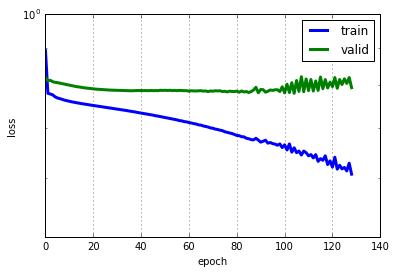

In [95]:
plot_net(net)

In [96]:
class LinearAdjustVariable(object):
    def __init__(self, name, start=0.03, stop=0.001):
        self.name = name
        self.start, self.stop = start, stop
        self.ls = None

    def __call__(self, nn, train_history):
        if self.ls is None:
            self.ls = np.linspace(self.start, self.stop, nn.max_epochs)

        epoch = train_history[-1]['epoch']
        new_value = float32(self.ls[epoch - 1])
        getattr(nn, self.name).set_value(new_value)

class EarlyStopping(object):
    def __init__(self, patience=100):
        self.patience = patience
        self.best_valid = np.inf
        self.best_valid_epoch = 0
        self.best_weights = None

    def __call__(self, nn, train_history):
        current_valid = train_history[-1]['valid_loss']
        current_epoch = train_history[-1]['epoch']
        if current_valid < self.best_valid:
            self.best_valid = current_valid
            self.best_valid_epoch = current_epoch
            self.best_weights = nn.get_all_params_values()
        elif self.best_valid_epoch + self.patience < current_epoch:
            print("Early stopping.")
            print("Best valid loss was {:.6f} at epoch {}.".format(
                self.best_valid, self.best_valid_epoch))
            nn.load_params_from(self.best_weights)
            raise StopIteration()

In [106]:
net = NeuralNet(
    layers = [
        ('input', layers.InputLayer),
        ('hidden1', layers.DenseLayer),
        ('hidden2', layers.DenseLayer),
        ('output', layers.DenseLayer)],
    input_shape=(None, 14),
    hidden1_num_units = 1000,
    hidden2_num_units = 1000,
    output_num_units = 3, output_nonlinearity = lasagne.nonlinearities.softmax,
    update=nesterov_momentum,
    update_learning_rate=theano.shared(float32(0.1)),
    update_momentum=theano.shared(float32(0.9)),
    max_epochs = 1000,
    verbose = 1,
    regression = True,
    on_epoch_finished=[
            LinearAdjustVariable('update_learning_rate', start=0.1, stop=0.0001),
            LinearAdjustVariable('update_momentum', start=0.9, stop=0.999),
            EarlyStopping(patience=20),
        ],
    objective_loss_function = lasagne.objectives.categorical_crossentropy)

In [107]:
net.fit(X_sub, y_sub)

# Neural Network with 1019003 learnable parameters

## Layer information

  #  name       size
---  -------  ------
  0  input        14
  1  hidden1    1000
  2  hidden2    1000
  3  output        3

  epoch    trn loss    val loss    trn/val  dur
-------  ----------  ----------  ---------  -----
      1     0.89226     0.81929    1.08906  8.85s
      2     0.78023     0.81161    0.96133  8.65s
      3     0.77801     0.81243    0.95763  8.61s
      4     0.77622     0.80870    0.95984  8.70s
      5     0.77132     0.80738    0.95533  8.76s
      6     0.76860     0.80692    0.95250  8.66s
      7     0.76722     0.80576    0.95217  8.62s
      8     0.76543     0.80441    0.95155  8.64s
      9     0.76388     0.80292    0.95138  8.63s
     10     0.76254     0.80132    0.95160  8.63s
     11     0.76119     0.79984    0.95167  8.63s
     12     0.76004     0.79854    0.95179  8.62s
     13     0.75908     0.79735    0.95200  8.63s
     14     0.75813     0.79615    0.95225  8.74s
 

NeuralNet(X_tensor_type=None,
     batch_iterator_test=<nolearn.lasagne.base.BatchIterator object at 0x7f443ac19d90>,
     batch_iterator_train=<nolearn.lasagne.base.BatchIterator object at 0x7f443ac19c90>,
     check_input=True, custom_scores=None, hidden1_num_units=1000,
     hidden2_num_units=1000, input_shape=(None, 14),
     layers=[('input', <class 'lasagne.layers.input.InputLayer'>), ('hidden1', <class 'lasagne.layers.dense.DenseLayer'>), ('hidden2', <class 'lasagne.layers.dense.DenseLayer'>), ('output', <class 'lasagne.layers.dense.DenseLayer'>)],
     loss=None, max_epochs=1000, more_params={},
     objective=<function objective at 0x7f443ac21848>,
     objective_loss_function=<function categorical_crossentropy at 0x7f443bc98410>,
     on_batch_finished=[],
     on_epoch_finished=[<__main__.LinearAdjustVariable object at 0x7f4427213ed0>, <__main__.LinearAdjustVariable object at 0x7f4427213c50>, <__main__.EarlyStopping object at 0x7f4427213490>, <nolearn.lasagne.handlers.PrintL

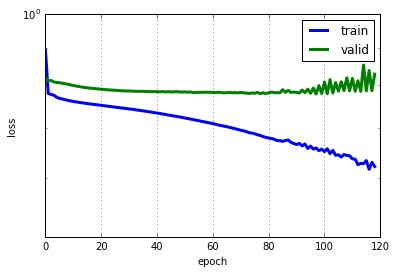

In [108]:
plot_net(net)

In [110]:
long_mean = df['longitude'].mean()
long_sd = df['longitude'].std()
df['longitude'] = df['longitude'].apply(lambda x: max(min(x, long_mean + 5*long_sd), long_mean - 5*long_sd))

In [111]:
lat_mean = df['latitude'].mean()
lat_sd = df['latitude'].std()
df['latitude'] = df['latitude'].apply(lambda x: max(min(x, lat_mean + 5*lat_sd), lat_mean - 5*lat_sd))

In [112]:
X = np.array(df[[col for col in df.columns if col != 'interest_level']], dtype = np.float)
X_max = X.max(axis = 0)
X_min = X.min(axis = 0)
X = (X - X_min) / (X_max - X_min)

In [113]:
subset = np.random.choice(X.shape[0], 1000, replace = False)
X_sub = X[subset]
y_sub = y[subset]

In [119]:
net = NeuralNet(
    layers = [
        ('input', layers.InputLayer),
        ('hidden1', layers.DenseLayer),
        ('hidden2', layers.DenseLayer),
        ('hidden3', layers.DenseLayer),
        ('output', layers.DenseLayer)],
    input_shape=(None, 14),
    hidden1_num_units = 800,
    hidden2_num_units = 1000,
    hidden3_num_units = 200,
    output_num_units = 3, output_nonlinearity = lasagne.nonlinearities.softmax,
    update=nesterov_momentum,
    update_learning_rate=theano.shared(float32(0.1)),
    update_momentum=theano.shared(float32(0.9)),
    max_epochs = 1000,
    verbose = 1,
    regression = True,
    on_epoch_finished=[
            LinearAdjustVariable('update_learning_rate', start=0.1, stop=0.0001),
            LinearAdjustVariable('update_momentum', start=0.9, stop=0.999),
            EarlyStopping(patience=50),
        ],
    objective_loss_function = lasagne.objectives.categorical_crossentropy)

In [120]:
net.fit(X_sub, y_sub)

# Neural Network with 1013803 learnable parameters

## Layer information

  #  name       size
---  -------  ------
  0  input        14
  1  hidden1     800
  2  hidden2    1000
  3  hidden3     200
  4  output        3

  epoch    trn loss    val loss    trn/val  dur
-------  ----------  ----------  ---------  -----
      1     0.91439     0.78578    1.16367  8.63s
      2     0.84220     0.78435    1.07375  8.57s
      3     0.82513     0.78160    1.05569  8.60s
      4     0.82117     0.78248    1.04945  8.56s
      5     0.82047     0.78203    1.04916  8.56s
      6     0.81865     0.78140    1.04766  8.56s
      7     0.81668     0.78065    1.04614  8.56s
      8     0.81452     0.78075    1.04326  8.59s
      9     0.81260     0.78041    1.04125  8.59s
     10     0.81022     0.78035    1.03828  8.78s
     11     0.80794     0.78040    1.03529  8.62s
     12     0.80531     0.78204    1.02975  8.78s
     13     0.80331     0.78560    1.02254  8.71s
     14     0.80168     0.7870

NeuralNet(X_tensor_type=None,
     batch_iterator_test=<nolearn.lasagne.base.BatchIterator object at 0x7f443ac19d90>,
     batch_iterator_train=<nolearn.lasagne.base.BatchIterator object at 0x7f443ac19c90>,
     check_input=True, custom_scores=None, hidden1_num_units=800,
     hidden2_num_units=1000, hidden3_num_units=200, input_shape=(None, 14),
     layers=[('input', <class 'lasagne.layers.input.InputLayer'>), ('hidden1', <class 'lasagne.layers.dense.DenseLayer'>), ('hidden2', <class 'lasagne.layers.dense.DenseLayer'>), ('hidden3', <class 'lasagne.layers.dense.DenseLayer'>), ('output', <class 'lasagne.layers.dense.DenseLayer'>)],
     loss=None, max_epochs=1000, more_params={},
     objective=<function objective at 0x7f443ac21848>,
     objective_loss_function=<function categorical_crossentropy at 0x7f443bc98410>,
     on_batch_finished=[],
     on_epoch_finished=[<__main__.LinearAdjustVariable object at 0x7f4426275fd0>, <__main__.LinearAdjustVariable object at 0x7f44262fc290>, <__ma

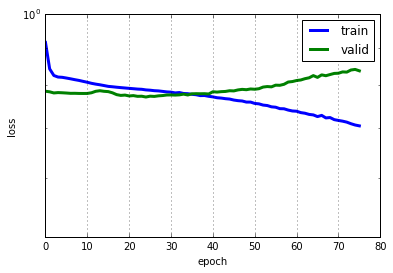

In [121]:
plot_net(net)

In [124]:
net = NeuralNet(
    layers = [
        ('input', layers.InputLayer),
        ('hidden1', layers.DenseLayer),
        ('dropout1', layers.DropoutLayer),
        ('hidden2', layers.DenseLayer),
        ('dropout2', layers.DropoutLayer),
        ('hidden3', layers.DenseLayer),
        ('output', layers.DenseLayer)],
    input_shape=(None, 14),
    hidden1_num_units = 800,
    dropout1_p = 0.2,
    hidden2_num_units = 1000,
    dropout2_p = 0.2,
    hidden3_num_units = 200,
    output_num_units = 3, output_nonlinearity = lasagne.nonlinearities.softmax,
    update=nesterov_momentum,
    update_learning_rate=theano.shared(float32(0.1)),
    update_momentum=theano.shared(float32(0.9)),
    max_epochs = 1000,
    verbose = 1,
    regression = True,
    on_epoch_finished=[
            LinearAdjustVariable('update_learning_rate', start=0.1, stop=0.0001),
            LinearAdjustVariable('update_momentum', start=0.9, stop=0.999),
            EarlyStopping(patience=50),
        ],
    objective_loss_function = lasagne.objectives.categorical_crossentropy)

In [125]:
net.fit(X_sub, y_sub)

# Neural Network with 1013803 learnable parameters

## Layer information

  #  name        size
---  --------  ------
  0  input         14
  1  hidden1      800
  2  dropout1     800
  3  hidden2     1000
  4  dropout2    1000
  5  hidden3      200
  6  output         3

  epoch    trn loss    val loss    trn/val  dur
-------  ----------  ----------  ---------  -----
      1     0.91988     0.78081    1.17811  8.92s
      2     0.84029     0.79001    1.06364  8.81s
      3     0.82578     0.78166    1.05645  8.67s
      4     0.82202     0.78406    1.04842  8.66s
      5     0.82071     0.78322    1.04787  8.66s
      6     0.81926     0.78339    1.04578  8.71s
      7     0.81863     0.78342    1.04495  8.67s
      8     0.81686     0.78304    1.04320  8.67s
      9     0.81616     0.78225    1.04336  8.66s
     10     0.81440     0.78130    1.04236  8.65s
     11     0.81257     0.78098    1.04046  8.66s
     12     0.80948     0.78066    1.03692  8.77s
     13     0.81036     0.785

NeuralNet(X_tensor_type=None,
     batch_iterator_test=<nolearn.lasagne.base.BatchIterator object at 0x7f443ac19d90>,
     batch_iterator_train=<nolearn.lasagne.base.BatchIterator object at 0x7f443ac19c90>,
     check_input=True, custom_scores=None, dropout1_p=0.2, dropout2_p=0.2,
     hidden1_num_units=800, hidden2_num_units=1000, hidden3_num_units=200,
     input_shape=(None, 14),
     layers=[('input', <class 'lasagne.layers.input.InputLayer'>), ('hidden1', <class 'lasagne.layers.dense.DenseLayer'>), ('dropout1', <class 'lasagne.layers.noise.DropoutLayer'>), ('hidden2', <class 'lasagne.layers.dense.DenseLayer'>), ('dropout2', <class 'lasagne.layers.noise.DropoutLayer'>), ('hidden3', <class 'lasagne.layers.dense.DenseLayer'>), ('output', <class 'lasagne.layers.dense.DenseLayer'>)],
     loss=None, max_epochs=1000, more_params={},
     objective=<function objective at 0x7f443ac21848>,
     objective_loss_function=<function categorical_crossentropy at 0x7f443bc98410>,
     on_batch_fin

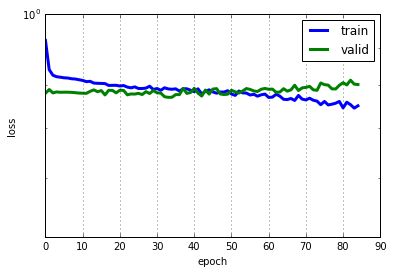

In [126]:
plot_net(net)

In [128]:
y_sub.mean(axis = 0)

array([ 0.077,  0.671,  0.252], dtype=float32)

In [129]:
-sum(y_sub.mean(axis = 0)*np.log(y_sub.mean(axis = 0)))

0.81248201429843903

Object `unlist` not found.
